# Performance Comparison: Pure Python vs Cythonized Implementation

This notebook provides a comprehensive performance analysis comparing the pure Python implementation (`dual_autodiff`) with its Cythonized version (`dual_autodiff_x`). We'll examine:

1. Basic Operations Performance
2. Mathematical Functions Performance
3. Scaling Analysis with Problem Size
4. Memory Usage and Efficiency
5. Real-world Application Benchmarks

In [1]:
# Import the benchmark code
from performance_benchmark import *

# Print package versions
print(f"Python version: {sys.version.split()[0]}")
print(f"NumPy version: {np.__version__}")

plt.style.use('mystyle.mplstyle')

dual_autodiff package version: 0.0.1
dual_autodiff_x package version: 0.0.1
Python version: 3.11.10
NumPy version: 1.26.4


## 1. Basic Operations Performance

Let's start by comparing the performance of basic operations between the two implementations:

,Operation,Python,Python_std,Cython,Cython_std,Speedup,Improvement
0,Creation,1.413963e-07,3.295201e-07,8.246442e-08,4.990733e-08,1.714634,41.678526
1,Addition,3.260430e-07,1.740190e-07,1.830875e-07,9.141672e-08,1.780804,43.845594
2,Multiplication,3.561011e-07,2.188828e-07,1.952858e-07,1.003746e-07,1.823487,45.160026
3,Division,4.038214e-07,2.076208e-07,2.272522e-07,9.489567e-08,1.776974,43.724572
4,Power,3.403615e-07,2.181478e-07,1.394497e-07,9.549375e-08,2.440747,59.028937


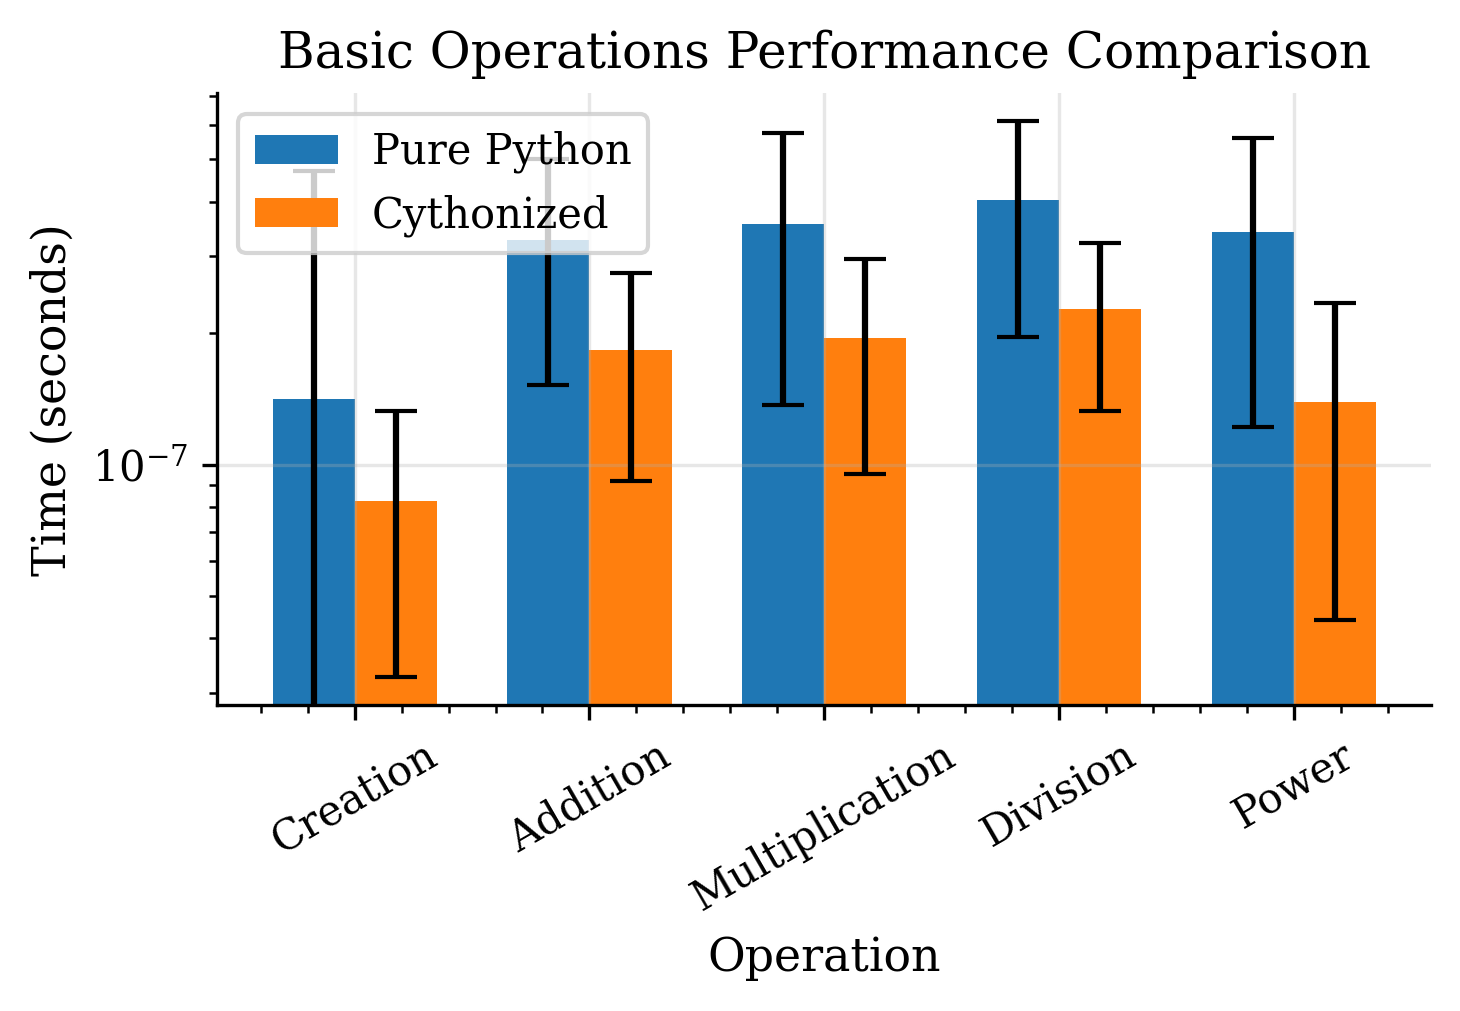

In [13]:
# Run basic operations benchmark
basic_ops_results = run_basic_operations_benchmark()

# Plot results
plot_performance_comparison(basic_ops_results, 
                          'Basic Operations Performance Comparison',
                          'Time (seconds)',
                          logscale=True)
plt.savefig('../report/images/basic_ops_performance.pdf', bbox_inches='tight')

basic_ops_results

## 2. Mathematical Functions Performance

Now let's compare the performance of mathematical functions:

,Function,Python,Python_std,Cython,Cython_std,Speedup,Improvement
0,Exponential,2.637238e-07,5.628636e-07,1.358343e-07,1.068629e-07,1.941511,48.493731
1,Sine,2.731724e-07,2.156167e-07,1.371761e-07,1.248026e-07,1.991399,49.784045
2,Cosine,2.801155e-07,2.166569e-07,1.309525e-07,7.887647e-08,2.139061,53.250522
3,Logarithm,2.874029e-07,2.499435e-07,1.291162e-07,7.204740e-08,2.225924,55.074844


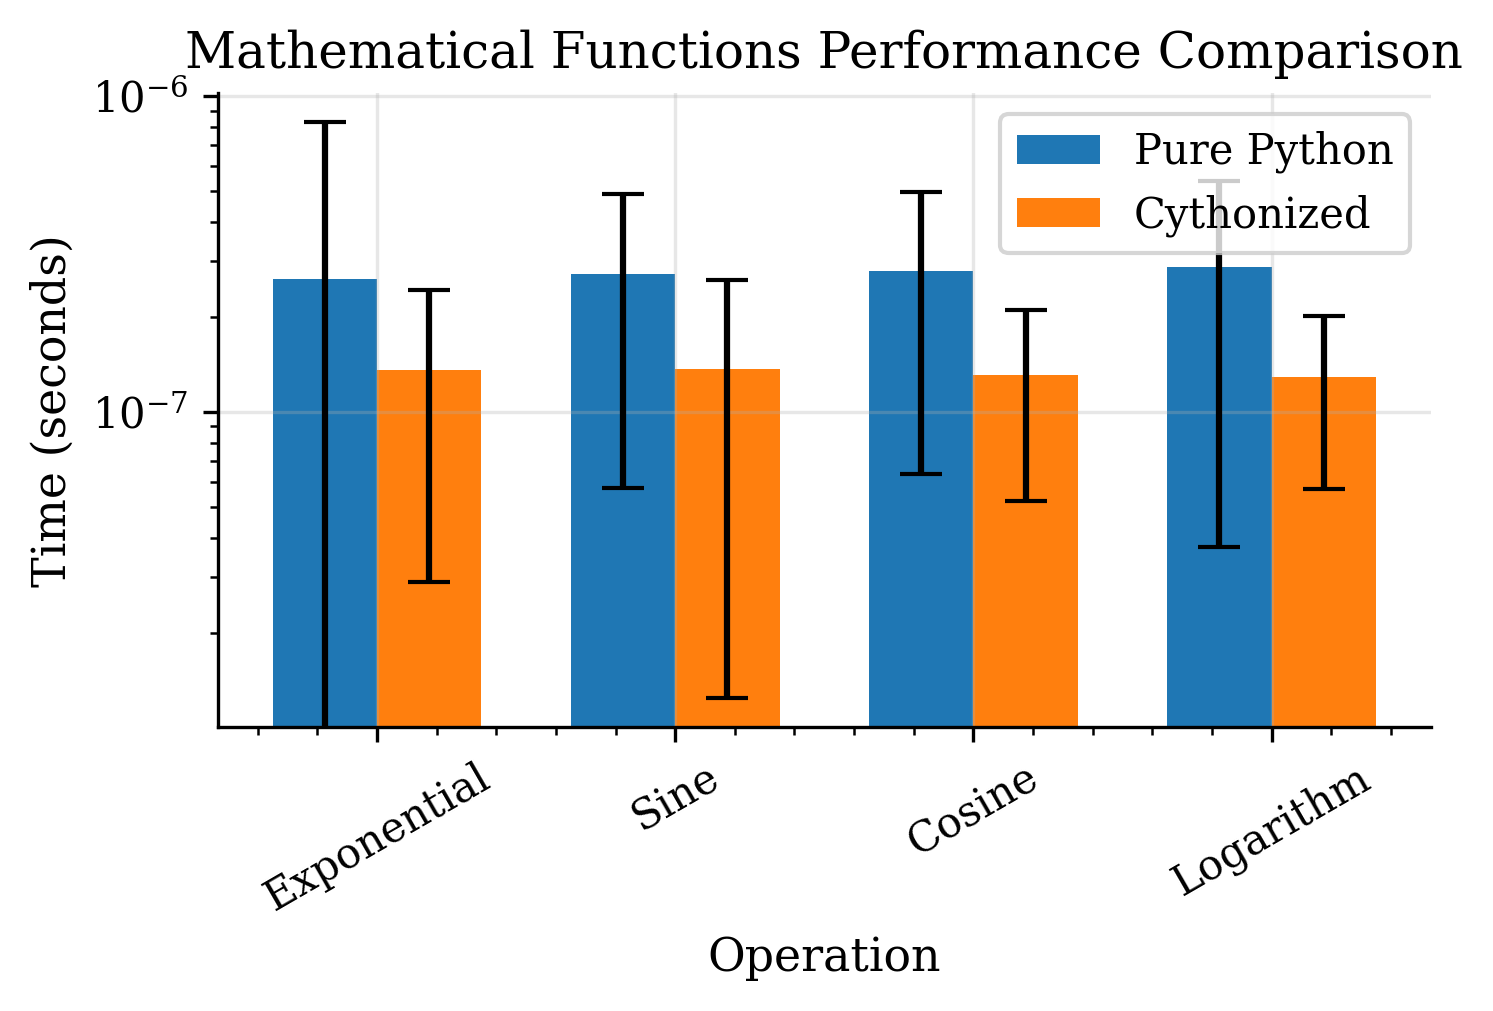

In [14]:
# Run mathematical functions benchmark
math_funcs_results = run_math_functions_benchmark()

# Plot results
plot_performance_comparison(math_funcs_results.rename(columns={'Function': 'Operation'}),
                          'Mathematical Functions Performance Comparison',
                          'Time (seconds)',
                          logscale=True)
plt.savefig('../report/images/math_funcs_performance.pdf', bbox_inches='tight')

math_funcs_results

## 3. Scaling Analysis

Let's analyze how performance scales with problem size using chain rule computations:

In [10]:
chain_lengths = [1, 2, 5, 10, 20, 50, 100]
scaling_results = []

def create_chain(n, impl):
    """Create a chain of n functions: f(f(...f(x)...))."""
    def chain(x):
        result = impl.Dual(x, 1.0)
        for _ in range(n):
            result = result.sin().exp().log()
        return result
    return chain

for n in chain_lengths:
    py_chain = create_chain(n, df)
    cy_chain = create_chain(n, dfx)
    
    py_results = measure_time(py_chain, 1.0, n_runs=100000)
    cy_results = measure_time(cy_chain, 1.0, n_runs=100000)
    
    speedup, improvement = calculate_speedup(py_results['mean'], cy_results['mean'])
    
    scaling_results.append({
        'Chain_Length': n,
        'Python': py_results['mean'],
        'Python_std': py_results['std'],
        'Cython': cy_results['mean'],
        'Cython_std': cy_results['std'],
        'Speedup': speedup,
        'Improvement': improvement
    })

scaling_results = pd.DataFrame(scaling_results)
scaling_results

,Chain_Length,Python,Python_std,Cython,Cython_std,Speedup,Improvement
0,1,6.928878e-07,1.333641e-06,2.898448e-07,1.795915e-07,2.390547,58.168574
1,2,1.056657e-06,4.072598e-07,4.268751e-07,2.468724e-07,2.475331,59.601359
2,5,2.382492e-06,1.909842e-06,8.630816e-07,4.225332e-07,2.760448,63.773999
3,10,4.316219e-06,1.055337e-06,1.507069e-06,5.202436e-07,2.863981,65.083571
4,20,8.412015e-06,1.181628e-06,2.835158e-06,5.488758e-07,2.967036,66.296329
5,50,2.009625e-05,1.624317e-06,6.974457e-06,1.079253e-05,2.881408,65.294743
6,100,4.099484e-05,3.712883e-06,1.319335e-05,1.375593e-06,3.107235,67.817048


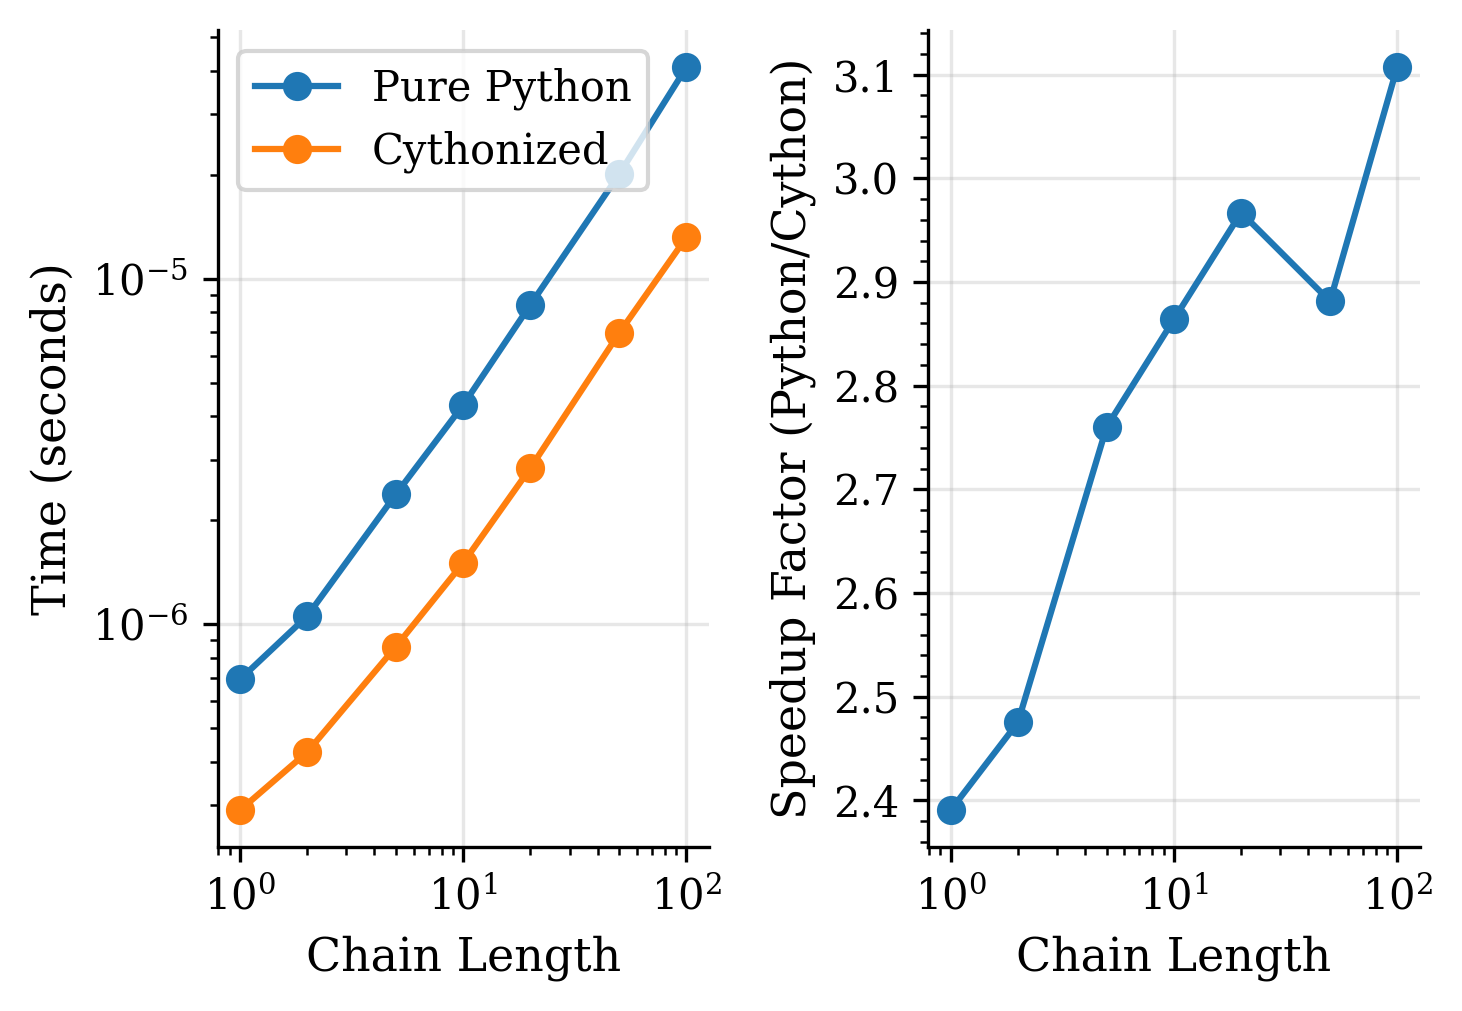

In [11]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2)

# Plot scaling results on the first subplot
ax[0].plot(scaling_results['Chain_Length'], scaling_results['Python'], 'o-', label='Pure Python')
ax[0].plot(scaling_results['Chain_Length'], scaling_results['Cython'], 'o-', label='Cythonized')
ax[0].set_xlabel('Chain Length')
ax[0].set_ylabel('Time (seconds)')
# ax[0].set_title('Performance Scaling with Chain Length')
ax[0].legend()
ax[0].grid(True, alpha=0.3)
ax[0].set_yscale('log')
ax[0].set_xscale('log')

# Plot speedup on the second subplot
ax[1].plot(scaling_results['Chain_Length'], scaling_results['Speedup'], 'o-')
ax[1].set_xlabel('Chain Length')
ax[1].set_ylabel('Speedup Factor (Python/Cython)')
# ax[1].set_title('Speedup Factor vs Chain Length')
ax[1].grid(True, alpha=0.3)
ax[1].set_xscale('log')

# Adjust layout
plt.tight_layout()
plt.savefig('../report/images/scaling_analysis.pdf', bbox_inches='tight')

## 4. Memory Usage Analysis

Let's analyze the memory efficiency of both implementations:

In [6]:
x_val = 2.0
array_sizes = [1000000, 5000000, 10000000]
memory_results = []

def create_array(size, impl):
    return [impl.Dual(x_val, 1.0) for _ in range(size)]

for size in array_sizes:
    # Measure array creation
    py_mem, py_array = measure_memory(create_array, size, df)
    cy_mem, cy_array = measure_memory(create_array, size, dfx)
    
    memory_results.append({
        'Operation': f'Array Creation (n={size})',
        'Python_Memory': py_mem,
        'Cython_Memory': cy_mem,
        'Memory_Ratio': py_mem / cy_mem if cy_mem > 0 else float('inf')
    })

memory_results = pd.DataFrame(memory_results)
memory_results

,Operation,Python_Memory,Cython_Memory,Memory_Ratio
0,Array Creation (n=1000000),87146496,48627712,1.792116
1,Array Creation (n=5000000),483770368,239517696,2.019769
2,Array Creation (n=10000000),858095616,477315072,1.797755


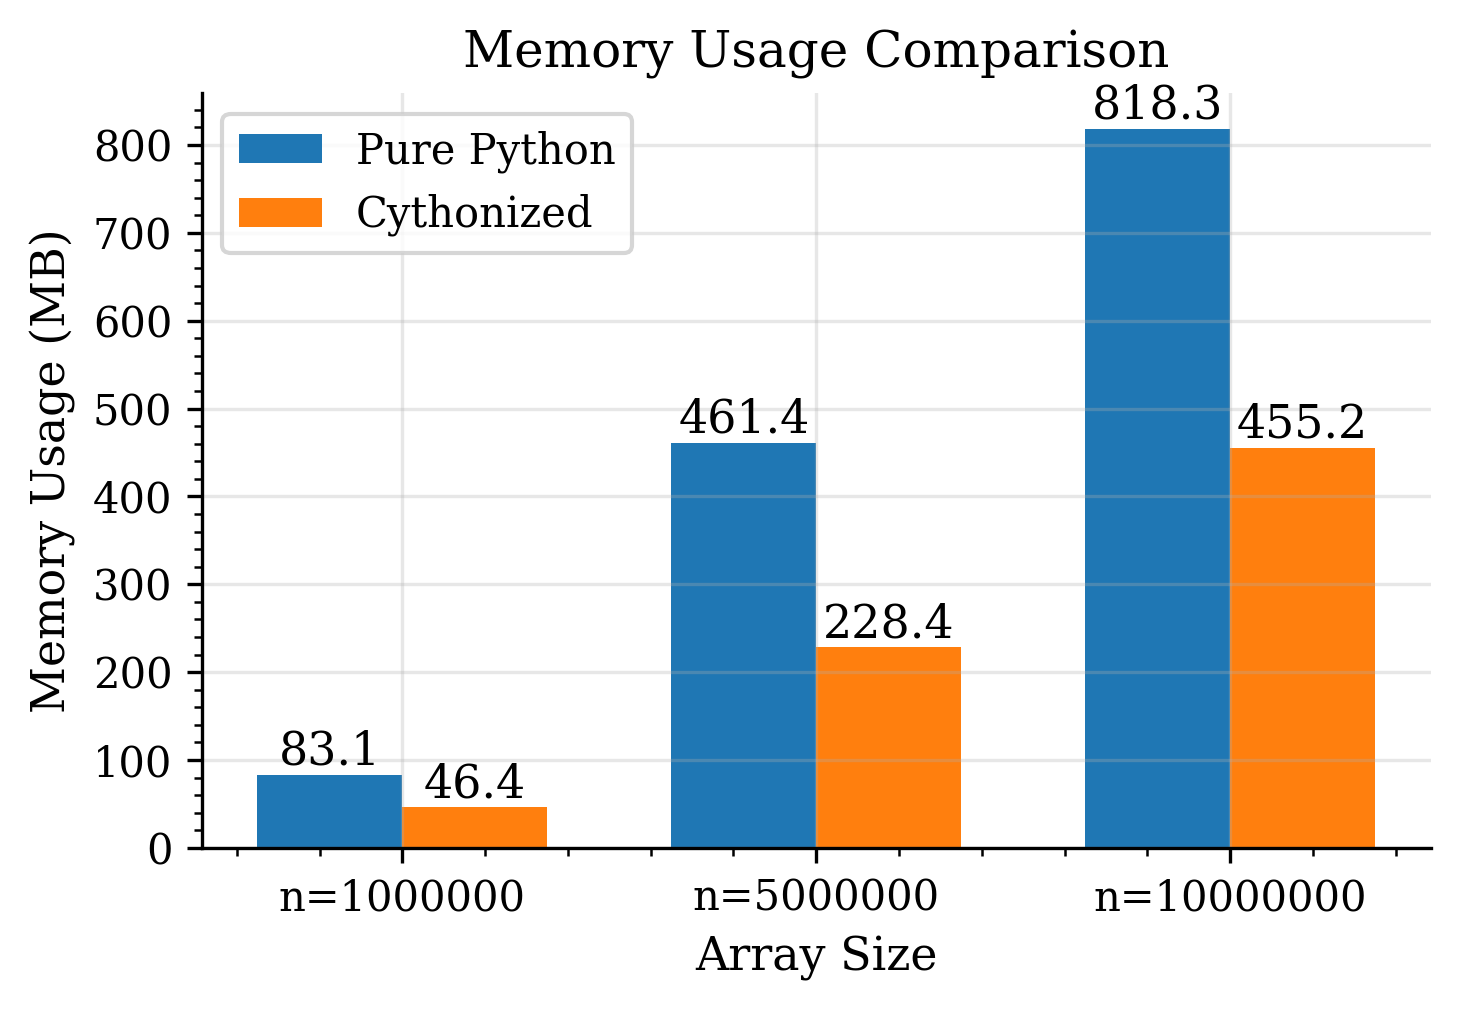

In [7]:
# Plot memory usage
plt.figure()
x = np.arange(len(memory_results))
width = 0.35

python_bars = plt.bar(x - width/2, memory_results['Python_Memory']/1024/1024, width, label='Pure Python')
cython_bars = plt.bar(x + width/2, memory_results['Cython_Memory']/1024/1024, width, label='Cythonized')
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')
autolabel(python_bars)
autolabel(cython_bars)

plt.xlabel('Array Size')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage Comparison')
plt.xticks(x, [f'n={size}' for size in array_sizes])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../report/images/memory_usage.pdf', bbox_inches='tight')

## 5. Real-world Application Benchmarks

Let's compare performance in practical applications:

,Application,Python,Python_std,Cython,Cython_std,Speedup,Improvement
0,Neural Network,0.000001,6.965141e-07,6.369012e-07,1.852265e-07,2.117045,52.764341
1,Gradient Computation,0.000001,6.264945e-07,5.563703e-07,1.825430e-07,2.606170,61.629510
2,Physics Simulation,0.000001,4.535637e-07,5.461647e-07,1.655150e-07,2.200305,54.551748


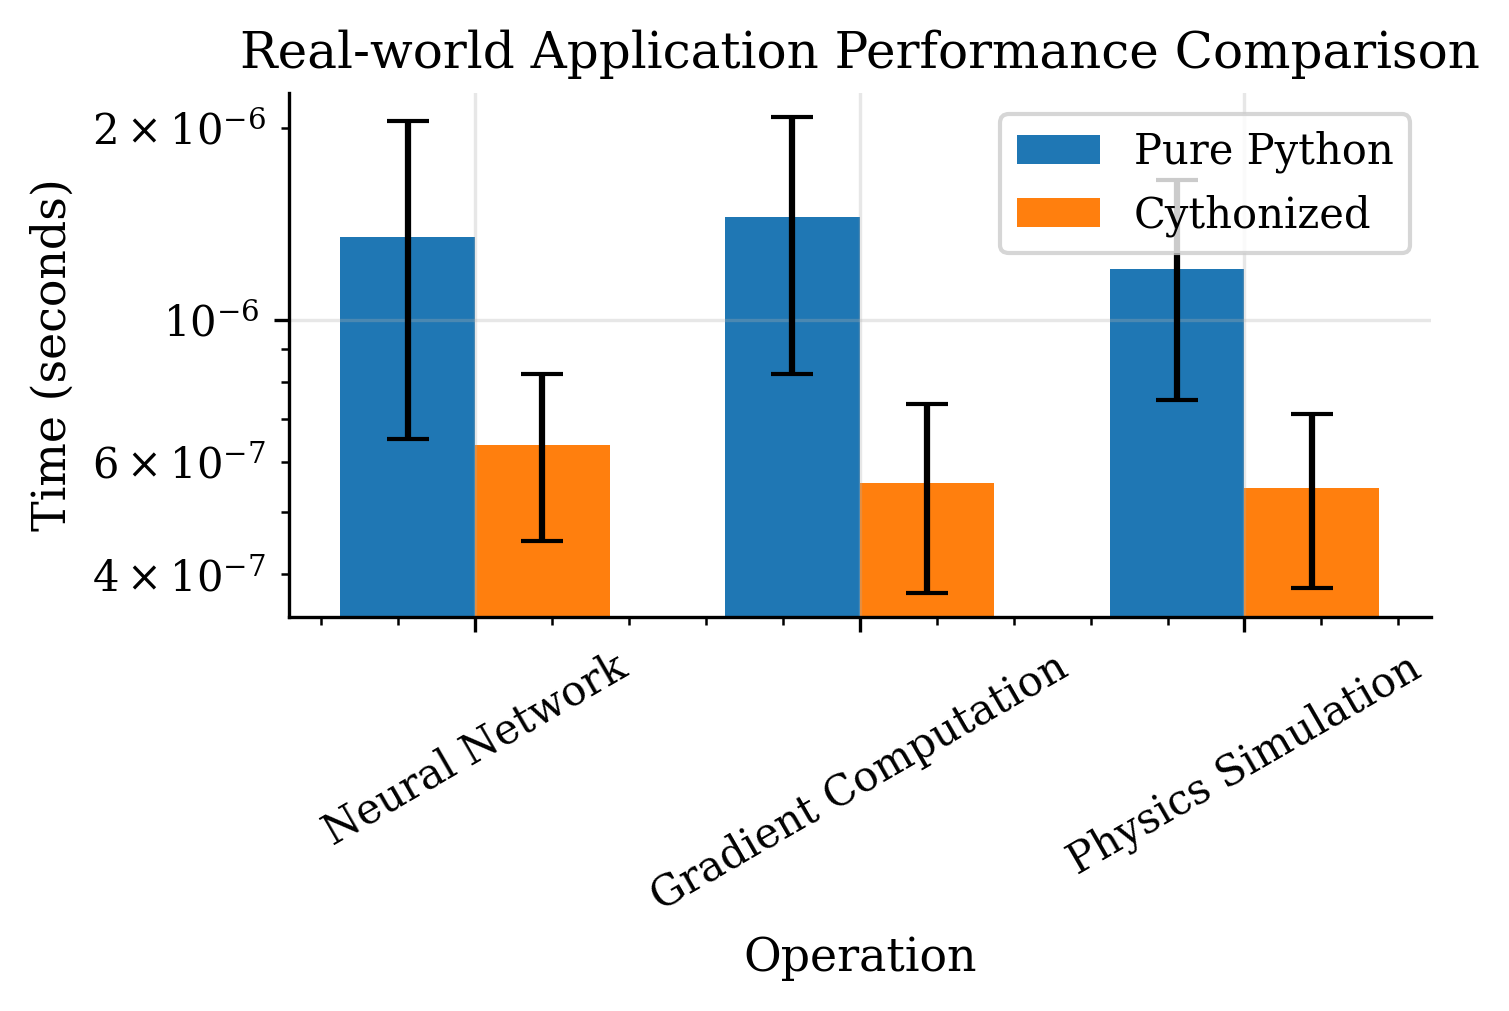

In [15]:
# Run application benchmarks
app_results = run_application_benchmarks()

# Plot results
plot_performance_comparison(app_results.rename(columns={'Application': 'Operation'}),
                          'Real-world Application Performance Comparison',
                          'Time (seconds)',
                          logscale=True)
plt.savefig('../report/images/app_performance.pdf', bbox_inches='tight')

app_results

## Overall Performance Summary

Let's summarize our findings across all benchmarks:

In [16]:
print("Overall Performance Summary")
print("=========================\n")

# Basic Operations
print("1. Basic Operations:")
print(f"   - Average speedup: {basic_ops_results['Speedup'].mean():.2f}x")
print(f"   - Best performing: {basic_ops_results.loc[basic_ops_results['Speedup'].idxmax(), 'Operation']} ({basic_ops_results['Speedup'].max():.2f}x)")
print(f"   - Average improvement: {basic_ops_results['Improvement'].mean():.1f}%\n")

# Mathematical Functions
print("2. Mathematical Functions:")
print(f"   - Average speedup: {math_funcs_results['Speedup'].mean():.2f}x")
print(f"   - Best performing: {math_funcs_results.loc[math_funcs_results['Speedup'].idxmax(), 'Function']} ({math_funcs_results['Speedup'].max():.2f}x)")
print(f"   - Average improvement: {math_funcs_results['Improvement'].mean():.1f}%\n")

# Scaling Analysis
print("3. Scaling Analysis:")
print(f"   - Maximum speedup: {scaling_results['Speedup'].max():.2f}x at chain length {scaling_results.loc[scaling_results['Speedup'].idxmax(), 'Chain_Length']}")
print(f"   - Speedup trend: {'Increases' if scaling_results['Speedup'].corr(scaling_results['Chain_Length']) > 0 else 'Decreases'} with chain length\n")

# Memory Usage
print("4. Memory Usage:")
print(f"   - Average memory ratio (Python/Cython): {memory_results['Memory_Ratio'].mean():.2f}")
print(f"   - Maximum memory savings: {(1 - 1/memory_results['Memory_Ratio'].max())*100:.1f}%\n")

# Real-world Applications
print("5. Real-world Applications:")
print(f"   - Average speedup: {app_results['Speedup'].mean():.2f}x")
print(f"   - Best performing: {app_results.loc[app_results['Speedup'].idxmax(), 'Application']} ({app_results['Speedup'].max():.2f}x)")
print(f"   - Average improvement: {app_results['Improvement'].mean():.1f}%\n")

# Overall Assessment
all_speedups = pd.concat([
    basic_ops_results['Speedup'],
    math_funcs_results['Speedup'],
    scaling_results['Speedup'],
    app_results['Speedup']
])

print("Overall Assessment:")
print(f"   - Global average speedup: {all_speedups.mean():.2f}x")
print(f"   - Performance improvement range: {all_speedups.min():.1f}x - {all_speedups.max():.1f}x")

Overall Performance Summary

1. Basic Operations:
   - Average speedup: 1.91x
   - Best performing: Power (2.44x)
   - Average improvement: 46.7%

2. Mathematical Functions:
   - Average speedup: 2.07x
   - Best performing: Logarithm (2.23x)
   - Average improvement: 51.7%

3. Scaling Analysis:
   - Maximum speedup: 3.11x at chain length 100
   - Speedup trend: Increases with chain length

4. Memory Usage:
   - Average memory ratio (Python/Cython): 1.87
   - Maximum memory savings: 50.5%

5. Real-world Applications:
   - Average speedup: 2.31x
   - Best performing: Gradient Computation (2.61x)
   - Average improvement: 56.3%

Overall Assessment:
   - Global average speedup: 2.33x
   - Performance improvement range: 1.7x - 3.1x
